In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#PCA
from sklearn.decomposition import PCA


In [ ]:
import psycopg2
import os
from dotenv import load_dotenv
load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection OK\n")
except Exception as e:
    print("Error:", e)

query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)
df_all['ind_code'] = df_all['ind_code'].str.strip()

df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

df['date_month'] = pd.to_datetime(df['date_month'])
df = df.set_index('date_month')
df = df.asfreq('MS')

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("Train:", train_data.shape)
print("Test :", test_data.shape)


Connection OK



/tmp/ipython-input-1234396426.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Train: (204, 10)
Test : (18, 10)


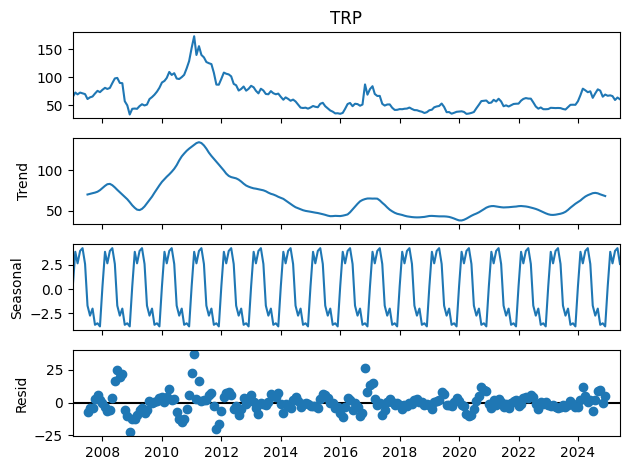

In [3]:
result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()


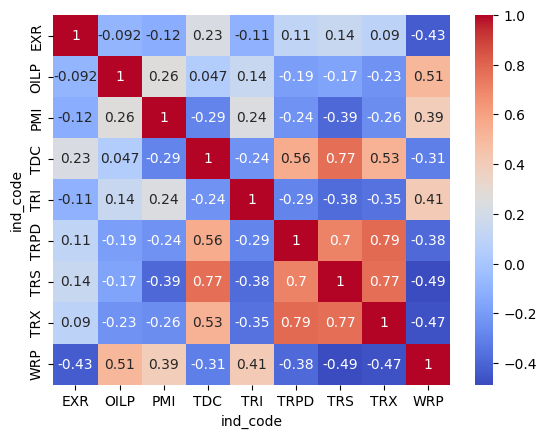

  Feature         VIF
0     EXR  220.368075
1    OILP   18.588115
2     PMI  287.031566
3     TDC   17.668887
4     TRI    2.857776
5    TRPD   40.515663
6     TRS   24.810917
7     TRX   84.202948
8     WRP   18.112380
EXR ADF=-2.7984, p=0.0585
OILP ADF=-2.9920, p=0.0356
PMI ADF=-6.2163, p=0.0000
TDC ADF=-0.2112, p=0.9372
TRI ADF=-2.2395, p=0.1922
TRPD ADF=-1.1591, p=0.6909
TRS ADF=-1.0853, p=0.7209
TRX ADF=-1.5220, p=0.5226
WRP ADF=-2.4895, p=0.1180


In [4]:
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

external_factors = ['EXR','OILP','PMI','TDC','TRI','TRPD','TRS','TRX','WRP']

train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

sns.heatmap(train_exog.corr(), annot=True, cmap='coolwarm')
plt.show()

vif_df = pd.DataFrame({
    "Feature": external_factors,
    "VIF": [variance_inflation_factor(train_exog.values, i)
            for i in range(len(external_factors))]
})
print(vif_df)

for col in external_factors:
    res = adfuller(train_data[col].dropna())
    print(f"{col} ADF={res[0]:.4f}, p={res[1]:.4f}")


In [5]:
full_train = train_data[['TRP'] + external_factors].copy()
full_test  = test_data[['TRP'] + external_factors].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(full_train)
test_scaled  = scaler.transform(full_test)

WINDOW = 12

def create_seq(data, win=WINDOW):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win, :])
        y.append(data[i+win, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_seq(train_scaled)
X_test, y_test   = create_seq(test_scaled)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (192, 12, 10)
X_test : (6, 12, 10)


In [6]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False,
         input_shape=(WINDOW, X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0584 - val_loss: 0.0015
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0175 - val_loss: 0.0014
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103 - val_loss: 5.6389e-04
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087 - val_loss: 0.0030
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - val_loss: 4.7079e-04
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [8]:
pred_scaled = model.predict(X_test)

dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
dummy[:,0] = pred_scaled[:,0]

pred = scaler.inverse_transform(dummy)[:,0]
actual = test_data['TRP'].iloc[WINDOW:].values

rmse = np.sqrt(mean_squared_error(actual, pred))
mape = mean_absolute_percentage_error(actual, pred)*100

print("LSTM RMSE:", rmse)
print("LSTM MAPE:", mape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
LSTM RMSE: 9.915466167209404
LSTM MAPE: 13.96056600768231


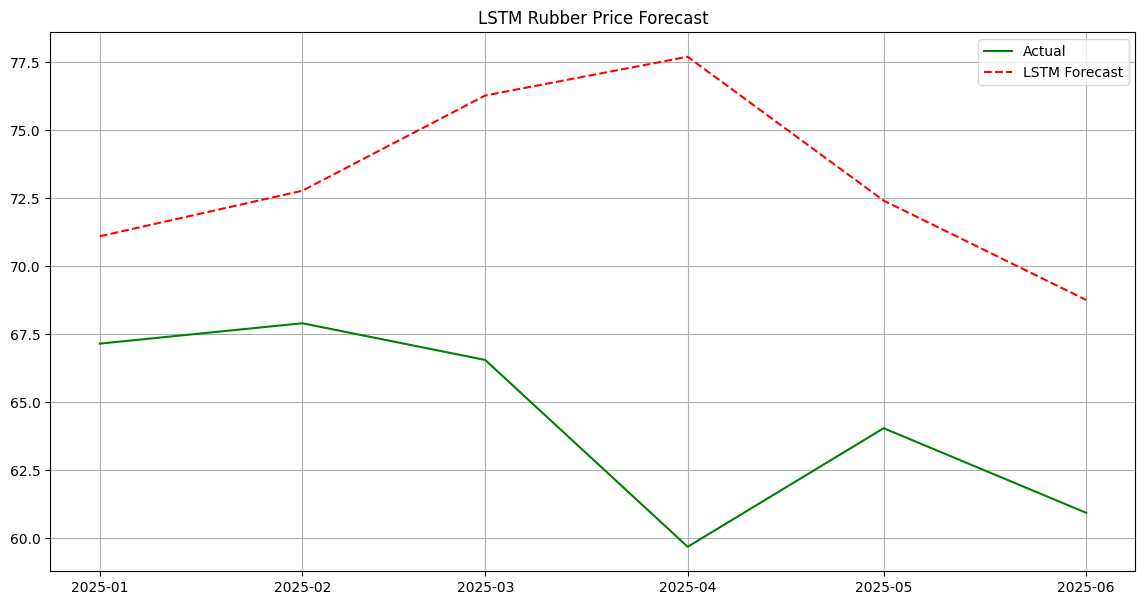

In [9]:
plt.figure(figsize=(14,7))
plt.plot(test_data.index[WINDOW:], actual, label='Actual', color='green')
plt.plot(test_data.index[WINDOW:], pred, label='LSTM Forecast', color='red', linestyle='--')
plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()


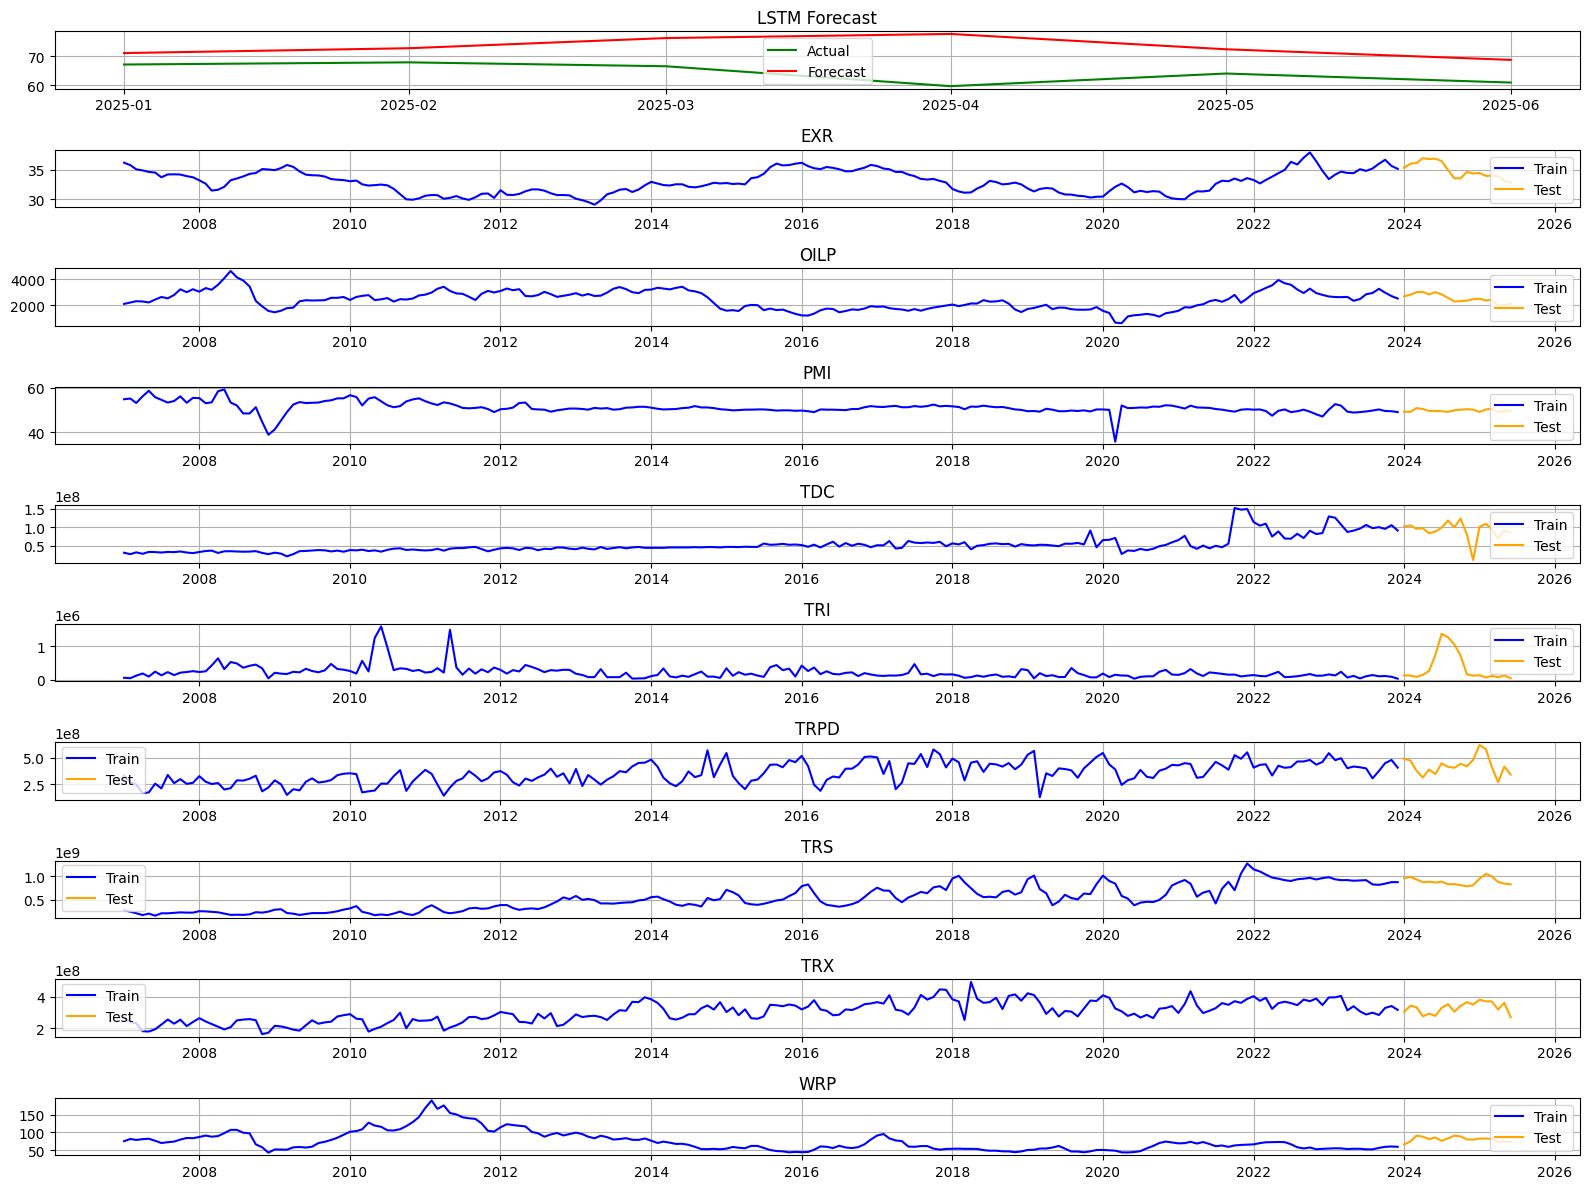

In [10]:
fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(16,12))

axes[0].plot(test_data.index[WINDOW:], actual, color='green', label='Actual')
axes[0].plot(test_data.index[WINDOW:], pred, color='red', label='Forecast')
axes[0].legend()
axes[0].set_title("LSTM Forecast")
axes[0].grid(True)

for i, fac in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[fac], color='blue', label='Train')
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test')
    ax.set_title(fac)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [12]:
print("\nPCA + LSTM")

approach_pca_lstm = []

scaler2 = StandardScaler()
train_scaled2 = scaler2.fit_transform(train_exog)
test_scaled2  = scaler2.transform(test_exog)

def seq_lstm(data, win=12):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win,:])
        y.append(data[i+win,0])
    return np.array(X), np.array(y)


for n_comp in range(2,10):

    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(train_scaled2)
    test_pca  = pca.transform(test_scaled2)

    explained = pca.explained_variance_ratio_.sum()

    #full matrix TRP + PCs
    train_full = np.concatenate([train_data[['TRP']].values, train_pca], axis=1)
    test_full  = np.concatenate([test_data[['TRP']].values, test_pca], axis=1)

    Xtr, ytr = seq_lstm(train_full)
    Xte, yte = seq_lstm(test_full)

    mdl = Sequential([
        LSTM(64, activation='tanh', return_sequences=False,
             input_shape=(12, train_full.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    mdl.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    mdl.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=200,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_unscaled = mdl.predict(Xte, verbose=0)

    # The model predicts unscaled TRP values, so no inverse transformation is needed.
    pred = pred_unscaled[:,0]

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mape = mean_absolute_percentage_error(yte, pred)*100

    print(f"{n_comp} comp | Var={explained*100:.1f}% | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

    approach_pca_lstm.append({
        "n_components": n_comp,
        "explained_var": explained,
        "RMSE": rmse,
        "MAPE": mape,
        "pred": pred,
        "true": yte
    })

best_pca_lstm = min(approach_pca_lstm, key=lambda x: x["RMSE"])

print("\n===== Best PCA+LSTM ====")
print("Components:", best_pca_lstm["n_components"])
print("Expl.Var :", best_pca_lstm["explained_var"]*100)
print("RMSE     :", best_pca_lstm["RMSE"])
print("MAPE     :", best_pca_lstm["MAPE"])


===== PCA + LSTM =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2 comp | Var=59.2% | RMSE=5.7122 | MAPE=7.97%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3 comp | Var=70.4% | RMSE=6.4474 | MAPE=8.98%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4 comp | Var=79.5% | RMSE=6.2898 | MAPE=8.72%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5 comp | Var=88.2% | RMSE=5.7861 | MAPE=8.01%
6 comp | Var=92.8% | RMSE=6.4840 | MAPE=9.05%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7 comp | Var=96.2% | RMSE=5.4081 | MAPE=7.41%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8 comp | Var=98.5% | RMSE=5.7014 | MAPE=8.35%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9 comp | Var=100.0% | RMSE=17.0766 | MAPE=25.89%

===== Best PCA+LSTM ====
Components: 7
Expl.Var : 96.20509133185004
RMSE     : 5.4081050926186
MAPE     : 7.409242179717916


Data Visualization

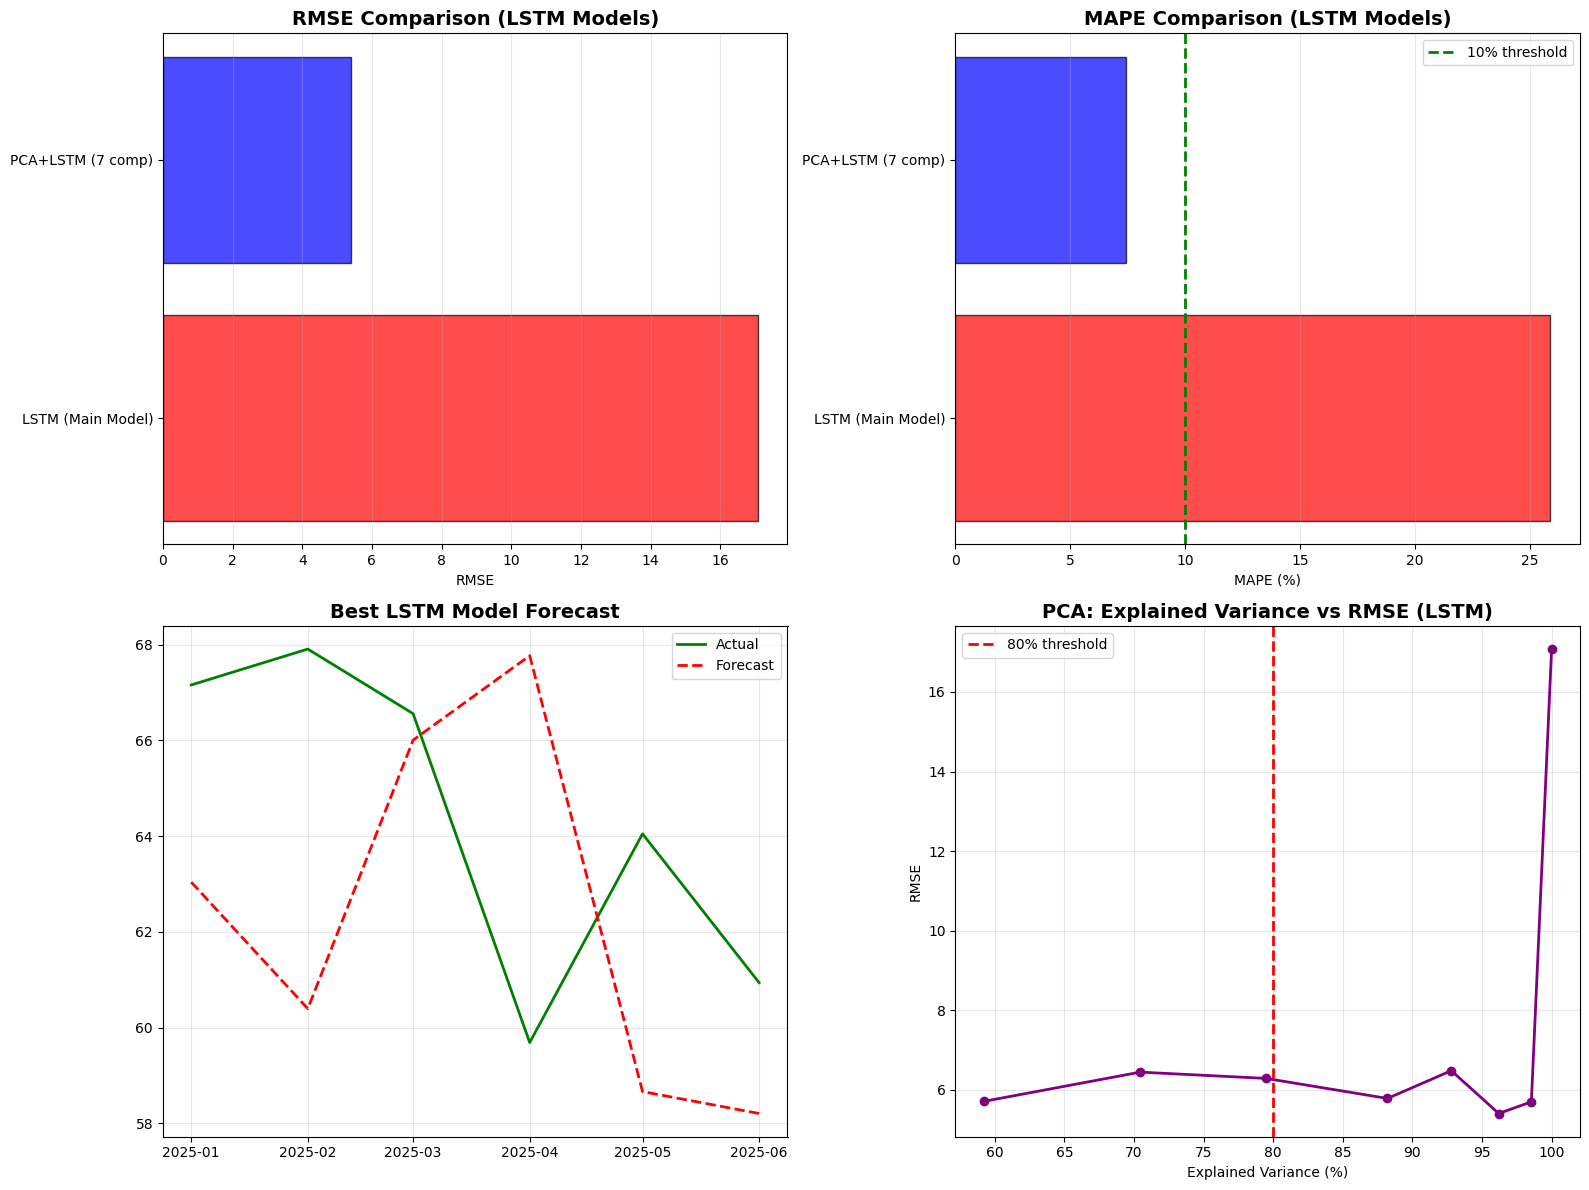

In [14]:
import matplotlib.pyplot as plt

#เทียบเฉพาะ LSTM Main + PCA+LSTM
all_approaches = [
    {
        "Method": "LSTM (Main Model)",
        "RMSE": rmse,
        "MAPE": mape
    },
    {
        "Method": f"PCA+LSTM ({best_pca_lstm['n_components']} comp)",
        "RMSE": best_pca_lstm['RMSE'],
        "MAPE": best_pca_lstm['MAPE']
    }
]

methods = [a["Method"] for a in all_approaches]
rmse_vals = [a["RMSE"] for a in all_approaches]
mape_vals = [a["MAPE"] for a in all_approaches]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#RMSE Comparison
ax = axes[0, 0]
ax.barh(methods, rmse_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.set_title("RMSE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("RMSE")
ax.grid(True, axis='x', alpha=0.3)


#MAPE Comparison
ax = axes[0, 1]
ax.barh(methods, mape_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='10% threshold')
ax.set_title("MAPE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("MAPE (%)")
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

#Best Model Forecast
best_overall = (
    best_pca_lstm
    if best_pca_lstm["RMSE"] < rmse
    else {"pred": pred, "true": actual}
)

ax = axes[1, 0]
#กรณีเป็น PCA+LSTM
if "true" in best_overall:
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["true"],
        label="Actual",
        color="green",
        linewidth=2
    )
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["pred"],
        label="Forecast",
        color="red",
        linestyle="--",
        linewidth=2
    )
else:
    #ถ้าเป็น main LSTM
    ax.plot(
        test_data.index[WINDOW:], actual, label='Actual', color='green', linewidth=2)
    ax.plot(
        test_data.index[WINDOW:], pred, label='Forecast', color='red', linestyle='--', linewidth=2)

ax.set_title("Best LSTM Model Forecast", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

#PCA vs RMSE Curve
ax = axes[1, 1]
exp_vars = [r['explained_var']*100 for r in approach_pca_lstm]
rmse_vals_pca = [r['RMSE'] for r in approach_pca_lstm]

ax.plot(exp_vars, rmse_vals_pca, marker='o', color='purple', linewidth=2)
ax.axvline(x=80, linestyle='--', color='red', linewidth=2, label='80% threshold')

ax.set_xlabel("Explained Variance (%)")
ax.set_ylabel("RMSE")
ax.set_title("PCA: Explained Variance vs RMSE (LSTM)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()